In [1]:
# Patient details file yaml/json
import yaml
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats

import seaborn as sns
plt.rcParams['lines.linewidth'] = 0.75

import numpy as np
import pandas as pd
def df_repr_latex(self):
    return '\n'.join([
        r'\vspace{5mm}',
        r'{\scriptsize{\centering{%s}}}' % self.to_latex(),
        r'\vspace{5mm}'
    ])
pd.DataFrame._repr_latex_ = df_repr_latex
from pandas.io.formats.style import Styler
Styler._repr_latex_ = lambda s: s.data._repr_latex_()

class HTMLLatex:
    def __init__(self, html, latex):
        self.html = html
        self.latex = latex
    def _repr_html_(self): return self.html
    def _repr_latex_(self): return self.latex
NewPage = HTMLLatex('<hr>', r'\clearpage\newpage')

from IPython.display import display, HTML, Latex

from dcmfetch import fetch_series
from mriqa.reports import (
    ghosting_report, slice_profile_report, piqt_distortion_report,
    uniformity_report, snr_report, snr_report_multi, svs_report, fid_report,
    phase_background_report, fbirn_full_report, mtf_report
)
from mriqa.phantoms import SIEMENSLONGBOTTLE, PIQTSP
from mriqa.tools import show_montage, watermark
from mriqa.dcmio import qa_date, scanner_operator, larmor_frequency, tales_reference_power, transmitter_calibration, gradient_sensitivities

# -- Watermark ---
wm = watermark()
display(
    pd.DataFrame(
        {'Watermark': list(wm.values())},
        index=wm.keys())
)

Watermark
CalculationTime  2022-02-21T17:07:18+00:00
User                        birchhub/rtrhd
PythonVersion                CPython 3.9.9
Platform          Linux 4.15.0-159-generic
mriqa                               0.2.10
dcmextras                            0.2.6
pydicom                              2.2.2
scipy                                1.7.3
numpy                               1.22.0
skimage                             0.19.1
matplotlib                           3.5.1

### Details of series to Analyse.
The Patient ID, the Study ID and the Series Numbers of the QA scans.

In [2]:
with open('study.yml') as fp:
    study_info = yaml.safe_load(fp)

patid, studyid = study_info['PatID'], study_info.get('StudyID', '1')
tests = study_info['Tests']
for k, test in tests.items():
    if 'PatID' not in test:
        test['PatID'] = patid
    if 'StudyID' not in test:
        test['StudyID'] = studyid

series = tests['SliceProfile_PIQT']['Series']['3mm']

d = fetch_series(patid, studyid, sernos=series)[0]
scanner, date_of_scan, operator = d.StationName, qa_date(d), scanner_operator(d, 'BIRCH')
display(
    pd.DataFrame(
        {'Details':[scanner, date_of_scan, patid, studyid]}, 
        index=['Scanner', 'Date', 'Patient', 'Study']
    )
)

Details
Scanner              AWP196245
Date                  20220120
Patient  AQA20220120SBCHLUMINA
Study         a85c2c05-9b97-4b

# Summary
Tests performed:

- Slice shape and profile
- Geometric distortion and linearity
- Resolution
- Ghosting
- Head coil image uniformity
- Head coil SNR

All of the above are acceptable.

----

### Recommended Actions

No actions necessary.

In [3]:
aqadate = (datetime.strptime(date_of_scan, '%Y%m%d') + timedelta(days=365)).strftime('%B %Y')

text = f'''
This machine is next due for Annual QA tests in {aqadate}.
'''

HTMLLatex(text, text)

----

In [4]:
text = f'''
BIRCH
Medical Physics & Bioengineering, UHBW
{datetime.strptime(date_of_scan, '%Y%m%d').strftime('%B %Y')}
'''

HTMLLatex(
    f'<pre>{text}</pre>',
    '\n'.join([
        r'\vfill',
        '\n',
        r'\begin{verbatim}',
        text,
        r'\end{verbatim}'
    ])
)

In [5]:
NewPage

# Detailed Results
The detailed results for each of the tests run are presented below.

----

## Slice Profile

These are the profiles of 3mm and 5mm slices in a conventional spin echo with a T<sub>E</sub> of 30ms using the PIQT slice profile block.

### 3 mm Slice

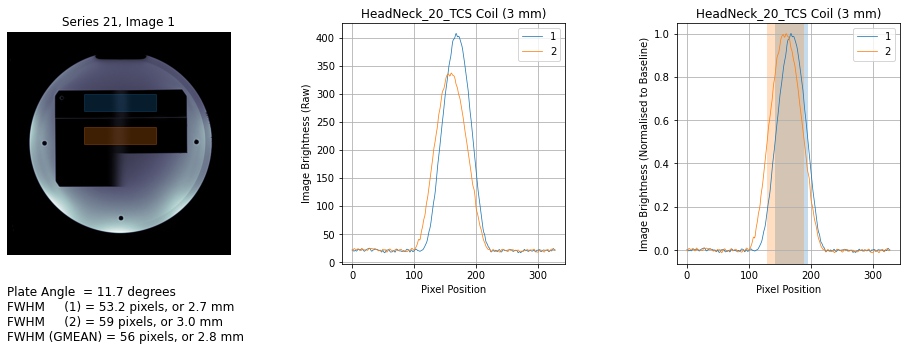

In [6]:
# TO2: Slice 3mm
info = tests['SliceProfile_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slice_idx = info['Series']['3mm'], info['Slice']['3mm']

# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
dobj = fetch_series(patid, studyid, sernos=series)[0]
results = slice_profile_report(dobj, frame=slice_idx, phantom=PIQTSP, flipped_ud=False, flipped_rl=False)

### 5 mm Slice

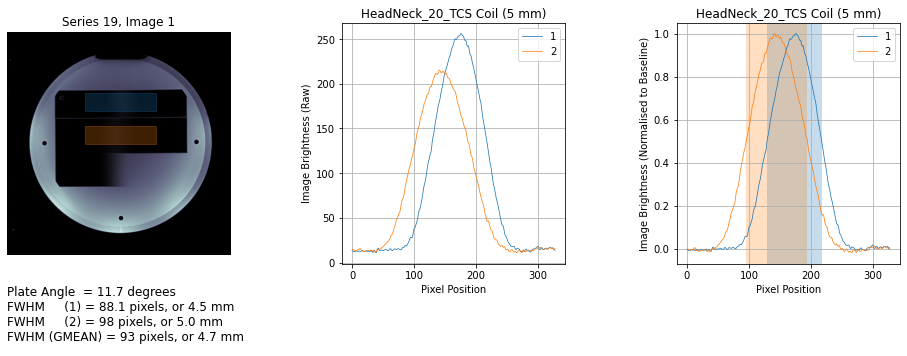

In [7]:
# TO2: Slice 5mm
# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
info = tests['SliceProfile_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slice_idx = info['Series']['5mm'], info['Slice']['5mm']

dobj = fetch_series(patid, studyid, sernos=series)[0]
result = slice_profile_report(dobj, frame=slice_idx, phantom=PIQTSP, flipped_ud=False, flipped_rl=False)
results = results.append(result)

In [8]:
pd.set_option('precision', 1)
results[['FWHMGMeanPixels', 'FWHMGMeanMM']].rename(columns={
    'FWHMGMeanPixels': 'Projected FWHM (pixels)',
    'FWHMGMeanMM': 'True FWHM (mm)'
})

Projected FWHM (pixels)  True FWHM (mm)
SliceThickness                                         
3.0                                56.3             2.8
5.0                                93.3             4.7

These are both rather rounded profiles as seen on other Siemens scanners with this protocol. The profile widths, though, are well within the AAPM tolerance of 0.5mm.

In [9]:
NewPage

## Image Scaling and Geometric Distortion

The PIQT phantom has a grid of objects for scale and distortion measurements in plane. The scale reflects the Gradient Sensitivity calibration performed by the manufacturer as part of the system installation. These results are *after* applying Siemens 2D distortion correction.

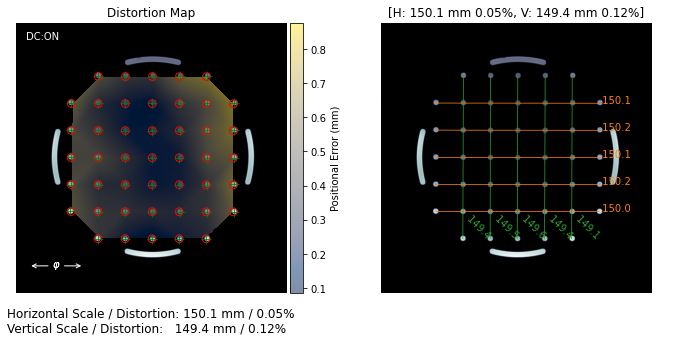

In [10]:
# PIQT: Distortion
info = tests['Distortion_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# SE: Axial, Phase RL, 512 matrix
dobj = fetch_series(patid, studyid, sernos=series['AxialRL_Corrected'])[0]
results = piqt_distortion_report(dobj, frame=slices['AxialRL_Corrected'])

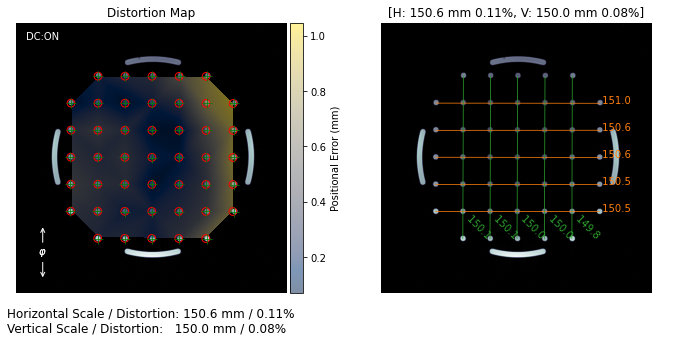

In [11]:
# PIQT: Distortion
# SE: Axial, Phase AP, 512 matrix
dobj = fetch_series(patid, studyid, sernos=series['AxialAP_Corrected'])[0]
results = results.append(piqt_distortion_report(dobj, frame=slices['AxialAP_Corrected']))

In [12]:
pd.set_option('precision', 3)
results[[
    'Orientation', 'PhaseDirection',
    'HorizontalScale', 'HorizontalDistortion',
    'VerticalScale', 'VerticalDistortion'
]].rename(columns={
    'PhaseDirection': 'Phase Direction',
    'HorizontalScale': 'Horizontal Scale (mm)', 'HorizontalDistortion':'Horizontal Distortion (%)',
    'VerticalScale': 'Vertical Scale (mm)', 'VerticalDistortion': 'Vertical Distortion (%)'  
})

Orientation Phase Direction  Horizontal Scale (mm)  \
Series                                                      
21           Axial              RL                150.127   
23           Axial              AP                150.646   

        Horizontal Distortion (%)  Vertical Scale (mm)  \
Series                                                   
21                          0.053              149.428   
23                          0.111              150.001   

        Vertical Distortion (%)  
Series                           
21                        0.116  
23                        0.078

The scale and distortion in both the RL and AP directions are well within 1% at the bandwidth used (260Hz/pixel).

In [13]:
NewPage

## Resolution

Image resolution is estimated by analysis of the MTF block in the PIQT phantom. These results are from an axial slice acquired using a conventional spin echo.

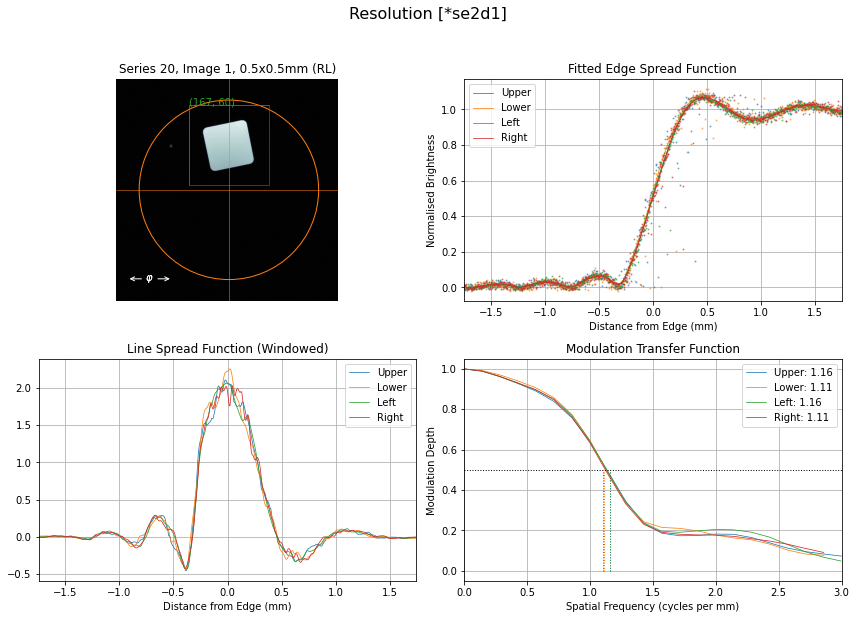

MTF_50
Upper   1.163
Lower   1.109
Left    1.161
Right   1.108

In [14]:
# PIQT: Resoution/MTF
info = tests['Resolution_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# SE: Axial, Phase RL, 512 matrix
dobj = fetch_series(patid, studyid, sernos=[series['SE512']])[0]
results = mtf_report(dobj, mtf_frame=slices['MTF'], centring_frame=slices['Centre'])
plt.show()
results

The MTF_50 is consistent with the nominal image resolution of 0.5 x 0.5 mm (1 cycle per mm).

In [15]:
NewPage

## Ghosting

Image ghosting is assessed following the approach of [AAPM report 100](https://www.aapm.org/pubs/reports/RPT_100.pdf) for the transverse orientation and four example sequences.

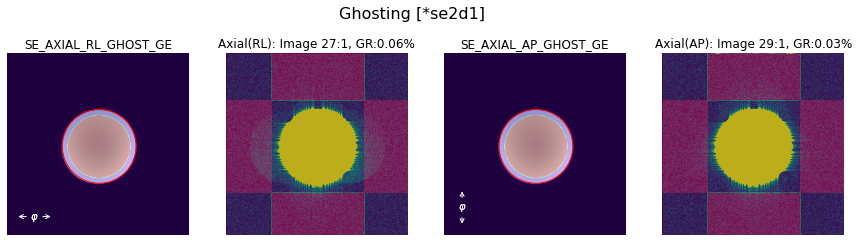

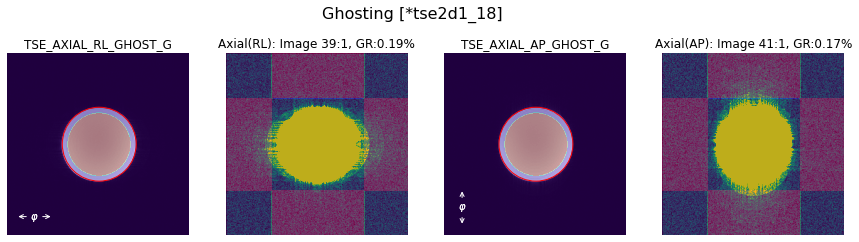

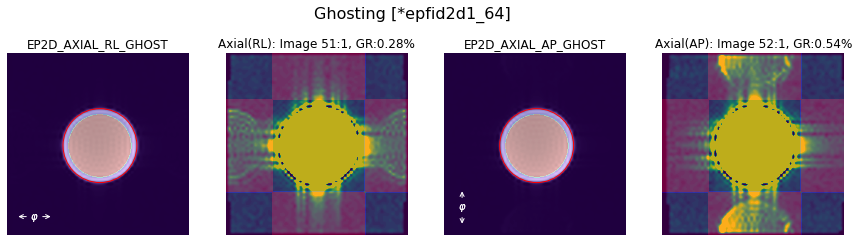

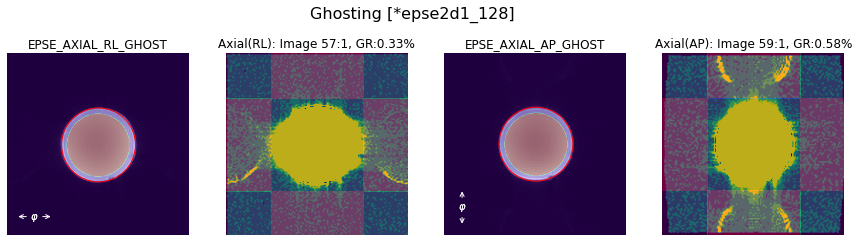

Sequence Orientation Phase Direction  Ghost Ratio (%)
Series                                                           
27            *se2d1       Axial              RL            0.057
29            *se2d1       Axial              AP            0.028
39        *tse2d1_18       Axial              RL            0.187
41        *tse2d1_18       Axial              AP            0.175
51      *epfid2d1_64       Axial              RL            0.283
52      *epfid2d1_64       Axial              AP            0.536
57      *epse2d1_128       Axial              RL            0.333
59      *epse2d1_128       Axial              AP            0.575

In [16]:
# GE10CM: Ghosting
info = tests['Ghosting_GE10']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

# SE Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['SE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = ghosting_report(dobjs, axes=list(axs.flat))

# TSE18 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['TSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))

# EPI64 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['EP2D']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

# EPISE128 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['EPSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

with pd.option_context('display.precision', 3):
    display(
        results[['Sequence', 'Orientation', 'PhaseDirection', 'GhostRatio']].rename(columns={
            'PhaseDirection': 'Phase Direction', 'GhostRatio': 'Ghost Ratio (%)'
        })
    )

The level of ghosting is under 1% for all sequences measured here including the EPIs. The worst ghosting is seen on the GRE EPI (EP_2D/epfid).

In [17]:
NewPage

## Receiver Coil Uniformity

We have tested the uniformity of the standard head/neck coil using a spherical phantom filled with a silicone oil. Results are presented both before and after Siemens `prescan-normalize` intensity correction.

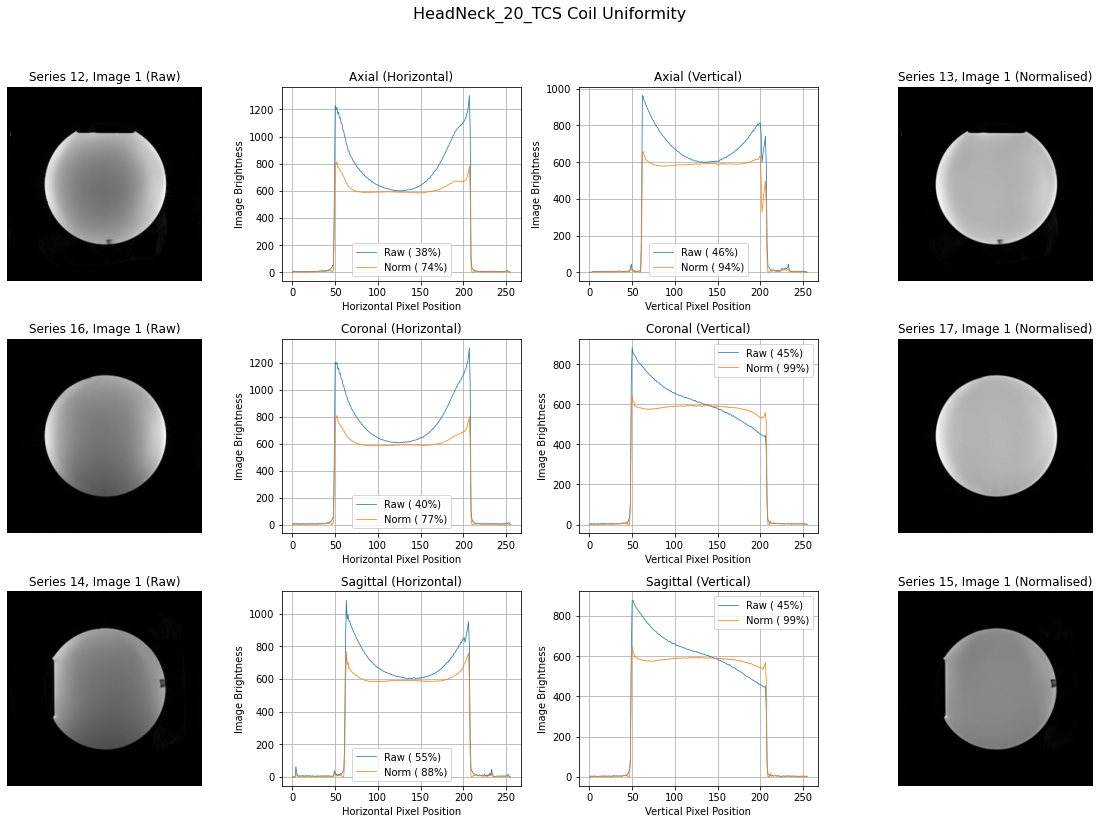

Raw Images


Series No.                    Protocol         Axis  \
Orientation                                                        
Axial                12  SE_AXIAL_RL_UNIF_OILSPHERE     Axial/RL   
Coronal              16    SE_COR_FH_UNIF_OILSPHERE   Coronal/RL   
Sagittal             14    SE_SAG_AP_UNIF_OILSPHERE  Sagittal/AP   

              X Uniformity (%)  Y Uniformity (%)  
Orientation                                       
Axial                    37.50             46.26  
Coronal                  40.00             45.28  
Sagittal                 54.73             45.28

Intensity Normalised Images


Series No.                    Protocol         Axis  \
Orientation                                                        
Axial                13  SE_AXIAL_RL_UNIF_OILSPHERE     Axial/RL   
Coronal              17    SE_COR_FH_UNIF_OILSPHERE   Coronal/RL   
Sagittal             15    SE_SAG_AP_UNIF_OILSPHERE  Sagittal/AP   

              X Uniformity (%)  Y Uniformity (%)  
Orientation                                       
Axial                    74.38             93.84  
Coronal                  76.88             99.37  
Sagittal                 87.67             99.37

In [18]:
# OILSPHERE: Uniformity
# SE Axial,Coronal,Sagittal; w w/o Intensity Normalization
info = tests['Uniformity_Oil']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

raw_tra = fetch_series(patid, stuid, sernos=series['Axial'][0])
psn_tra = fetch_series(patid, stuid, sernos=series['Axial'][1])
raw_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][0])
psn_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][1])
raw_cor = fetch_series(patid, stuid, sernos=series['Coronal'][0])
psn_cor = fetch_series(patid, stuid, sernos=series['Coronal'][1])

if len(raw_tra) > 1:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
        raw_dobjsb=[raw_tra[1], raw_sag[1], raw_cor[1]],
        psn_dobjsb=[psn_tra[1], psn_sag[1], psn_cor[1]]
    )
else:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
    )

plt.show()

with pd.option_context('display.precision', 2):
    print('Raw Images')
    display(
        results[['SeriesRaw',  'ProtocolRaw',  'OrientRaw', 'XUniformityRaw', 'YUniformityRaw']].rename(columns={
            'SeriesRaw': 'Series No.', 'ProtocolRaw': 'Protocol', 'OrientRaw': 'Axis',
            'XUniformityRaw': ' X Uniformity (%)', 'YUniformityRaw': 'Y Uniformity (%)'
        })
    )
    print('Intensity Normalised Images')
    display(
        results[['SeriesNorm', 'ProtocolNorm', 'OrientNorm', 'XUniformityNorm', 'YUniformityNorm']].rename(columns={
            'SeriesNorm': 'Series No.', 'ProtocolNorm': 'Protocol', 'OrientNorm': 'Axis',
            'XUniformityNorm': ' X Uniformity (%)', 'YUniformityNorm': 'Y Uniformity (%)'
        })
    )

As expected for a multi-element coil the uncorrected images are significantly non-uniform. However, the Siemens `prescan-normalize` intensity correction is adequate in compensating for this. The drop in uniformity in the X-axis for the axial and coronal views appears to be primarily due to a change to normalising to a set value rather than an average over the FoV, and does not necessarily translate into increased visible nonuniformity. There is some reduction in raw performance; this may be due in part to positioning errors, but should be monitored at future visits.

In [19]:
NewPage

## Signal to Noise

The Siemens QA involves a comprehensive element by element assessment of the SNR of all the coils. For reference purposes the following is an independent estimate for the standard head/neck coil using the Siemens long bottle phantom. The SNR is estimated over centred discs with diameters 50% and 75% of the phantom. The signal is taken from a region within the phantom in the mean of two images and the noise is estimated from a background region in their difference image.

### 20 Channel Head/Neck Coil

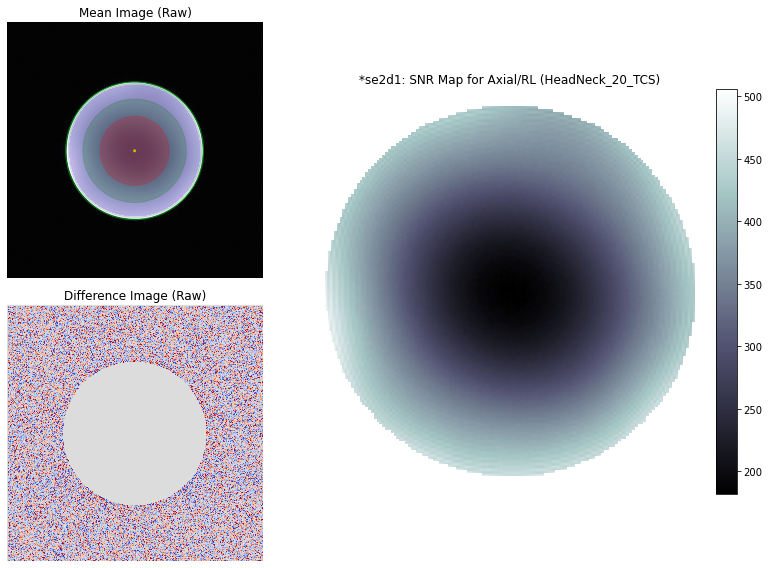

SNR: Raw Images


HeadNeck_20_TCS
RegionSize                 
0.50                  238.0
0.75                  292.0

In [20]:
# LONGBOTTLE: Signal to Noise
info = tests['QuarterlySNR']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

raw_tra = fetch_series(patid, stuid, sernos=series['Signal_Combined'])
if len(raw_tra) > 1:
    results = snr_report(raw_dobjs=[raw_tra[0]], raw_dobjsb=[raw_tra[1]])
else:
    results = snr_report(raw_dobjs=[raw_tra[0]])
plt.show()

print('SNR: Raw Images')
with pd.option_context('display.precision', 2):
    display(np.round(results))

These results are consistent with previous results from this scanner.

In [21]:
NewPage

### Single-element Images
This is the SNR calculated from individual element images combined as a sum of squares. This is the methodology used in the quarterly QA.

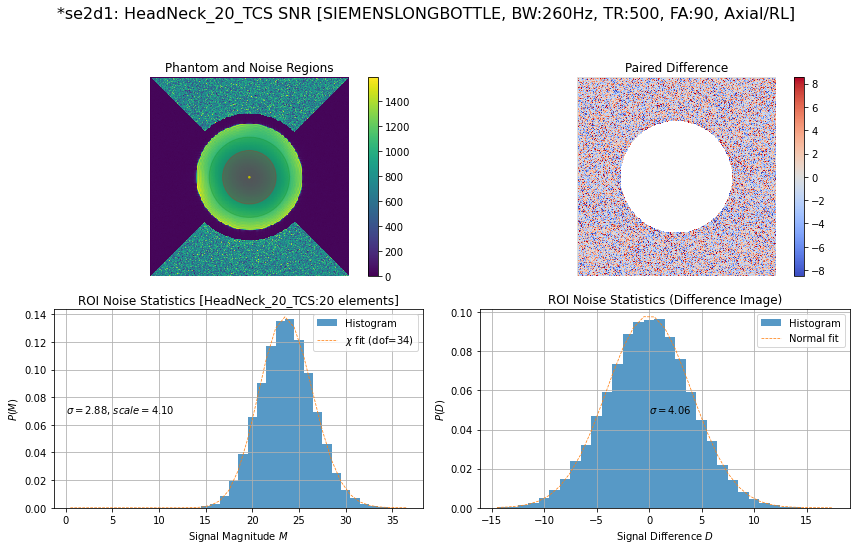

HeadNeck_20_TCS
0.50           241.08
0.75           295.92

In [22]:
# SNR (uncombined channels)
from mriqa.dcmio import coil_elements
dobjs = sorted(
    fetch_series(patid, stuid, series['Signal']),
    key=lambda x: (int(x.SeriesNumber), int(x.AcquisitionNumber), coil_elements(x)[0])
)
nchannels = len(set(coil_elements(d)[0] for d in dobjs))
dobjsa, dobjsb = dobjs[:nchannels], dobjs[nchannels:]

results = snr_report_multi(dobjsa, dobjsb, phantom=SIEMENSLONGBOTTLE)
plt.show()
with pd.option_context('display.precision', 2):
    display(results)

These results are consistent with previous results from this scanner.

In [23]:
NewPage

### Frequency Reference and Transmitter Voltage
These are the reference values reported in the DICOM header of the Localizer scan.

In [24]:
info = tests['TuneupParams']
patid, studyid = info['PatID'], info['StudyID']
series = info['Series']
dobj = fetch_series(patid, studyid, sernos=series)[0]

df = pd.DataFrame({
    'ImagingFrequency': [larmor_frequency(dobj)],
    'TransmitterCalibration': [transmitter_calibration(dobj)],
    'TalesReferencePower': [tales_reference_power(dobj)],
    'GradientSensitivityX': [
        float(gradient_sensitivities(dobj)[0]) * 1e6,
    ],
    'GradientSensitivityY': [
        float(gradient_sensitivities(dobj)[1]) * 1e6,
    ],
    'GradientSensitivityZ': [
        float(gradient_sensitivities(dobj)[2]) * 1e6,
    ]
}, index=['Value']).T
df

Value
ImagingFrequency         123.257
TransmitterCalibration   449.112
TalesReferencePower     2870.150
GradientSensitivityX      92.940
GradientSensitivityY      94.129
GradientSensitivityZ      91.739